# Analysis of TES Data
## Using feature reduction and clustering
One script to rule them all!

In [89]:
# import libraries
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import mplcursors
import pyperclip
import datetime
import cupy as cp
import seaborn as sns

from matplotlib.patches import ConnectionPatch
from matplotlib.colors import ListedColormap
from matplotlib.widgets import RectangleSelector
from matplotlib.patches import Rectangle
from readTrc import Trc
from scipy import signal
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from sklearn import manifold
from matplotlib.dates import DateFormatter

%matplotlib widget


# Load data

In [90]:
# This is the directory for the dataCR_ for the anabsalysis
data_dir            = './TES Only/'
channels            = ['C1','C2','C3','C4']

# Load the data per channel
filenames           = {channel: [file for file in os.listdir(data_dir) if channel in file] for channel in channels}
# Dont forget to sort them so that coincidences will match up correctly
for channel in channels:
    filenames[channel]=np.sort(filenames[channel])
    
# Load the data
trc_loader          = Trc()   # Create a loader object
traces              = {channel: [trc_loader.open(os.path.join(data_dir,filename)) for filename in filenames[channel]] for channel in channels}
ch = 'C1'
# Note event times
print(len(traces[ch]))
print(traces[ch][0][2]['TRIGGER_TIME'])
print(traces[ch][len(traces[ch])-1][2]['TRIGGER_TIME'])
print(traces[ch][len(traces[ch])-1][2]['TRIGGER_TIME']-traces[ch][0][2]['TRIGGER_TIME'])

# Load the Reference Pulses
reference_pulses    = pd.read_csv('./DATA/REFERENCE/reference.dat', skiprows=5, header=[0,1], sep='\t')

1215
2023-10-19 17:52:50.978630
2023-10-20 09:13:31.089999
15:20:40.111369


In [91]:
# Implement time cuts
# starttime=datetime.datetime(2023,7,14, 15,54) #second throium
# endtime=datetime.datetime(2023,7,15, 9,32) #second throium

# If there is an offset
#oscilloscope_offset=datetime.timedelta(minutes=44)
#starttime=datetime.datetime(2023,7,6,18,46,16)+oscilloscope_offset ##times for initial run
#endtime=datetime.datetime(2023,7,7, 7,30,15)+oscilloscope_offset ##times for initial run
#starttime=datetime.datetime(2023,7,7,19,28,1) ##times for weeked run
#endtime=datetime.datetime(2023,7,8,7,5,51)##times for weeked run
# starttime=datetime.datetime(2023,10,2, 18,32,19) #DCR 02102023 Lito2 E20
# endtime=datetime.datetime(2023,10,3, 10,17,21) #DCR 02102023 Lito2 E20

# starttime=datetime.datetime(2023,10,9, 18,58,52) #DCR Lito2 B20
# endtime=datetime.datetime(2023,10,10, 9,44,31) #DCR Lito2 B20

# intimetraces={channel:[] for channel in channels}
# for channel in channels:
#     for trace in traces[channel]:
#         if (trace[2]['TRIGGER_TIME']<endtime and trace[2]['TRIGGER_TIME']>starttime):
#             intimetraces[channel].append(trace)     
# traces=intimetraces

In [92]:
# plt.figure()
# plt.plot(reference_pulses)
# plt.show()

# Data info

In [93]:
# Check loaded event's name and total number of signals
print(traces[ch][1][2])
print(len(traces[ch]))

{'INSTRUMENT_NAME': 'LECROYWR620Zi', 'INSTRUMENT_NUMBER': 61171, 'TRACE_LABEL': '', 'WAVE_ARRAY_COUNT': 2502, 'PNTS_PER_SCREEN': 2500, 'FIRST_VALID_PNT': 0, 'LAST_VALID_PNT': 2501, 'FIRST_POINT': 0, 'SPARSING_FACTOR': 1, 'SEGMENT_INDEX': 0, 'SUBARRAY_COUNT': 1, 'SWEEPS_PER_ACQ': 1, 'POINTS_PER_PAIR': 0, 'PAIR_OFFSET': 0, 'VERTICAL_GAIN': 9.72929956333246e-06, 'VERTICAL_OFFSET': 0.21699999272823334, 'MAX_VALUE': 30579.0, 'MIN_VALUE': -30835.0, 'NOMINAL_BITS': 8, 'NOM_SUBARRAY_COUNT': 1, 'HORIZ_INTERVAL': 3.999999975690116e-08, 'HORIZ_OFFSET': -2.063101573465788e-05, 'PIXEL_OFFSET': -2.06e-05, 'VERTUNIT': 'V', 'HORUNIT': 'S', 'HORIZ_UNCERTAINTY': 9.999999960041972e-13, 'TRIGGER_TIME': datetime.datetime(2023, 10, 19, 17, 53, 22, 183999), 'ACQ_DURATION': 0.0, 'RECORD_TYPE': 'single_sweep', 'PROCESSING_DONE': 'no_processing', 'RIS_SWEEPS': 1, 'TIMEBASE': '10_us/div', 'VERT_COUPLING': 'AC,_1MOhm', 'PROBE_ATT': 1.0, 'FIXED_VERT_GAIN': '50_mV/div', 'BANDWIDTH_LIMIT': True, 'VERTICAL_VERNIER': 

# Oscilloscope Parameters

In [94]:
# The settings of the oscilloscope
REFERENCE_VOLTAGE   = signal.resample(reference_pulses['Amp_2ph_1.6eV'].to_numpy().T[0],len(traces[ch][0][0]))
trig_ch0 = -0.02
trig_ch1 = -0.031

# Filter the traces


In [95]:
if ch == 'C1':
    # Select the traces that had nonzero signal (can add ch3 and ch4 in case we need PMT coincidence as well)
    mask_ch0          = [np.min(data[1]) < trig_ch0 for data in traces[ch]] #0.052
    idx_triggered_ch0 = np.where(np.array(mask_ch0))[0]
    triggered_ch0     = [traces[ch][i] for i in idx_triggered_ch0]
    print(np.unique(mask_ch0,return_counts=True))
if ch == 'C2':
    mask_ch0          = [np.min(data[1]) < trig_ch1 for data in traces[ch]] #0.052
    idx_triggered_ch0 = np.where(np.array(mask_ch0))[0]
    triggered_ch0     = [traces[ch][i] for i in idx_triggered_ch0]
    print(np.unique(mask_ch0,return_counts=True))

the_data          = triggered_ch0
the_data_index    = idx_triggered_ch0

(array([False,  True]), array([   1, 1214]))


In [96]:
baseline = []
# print(the_data[1213][1][:450])
# print(the_data_index)
for i in the_data_index[:-1]:
    baseline.append(the_data[i][1][:450])
baseline = np.concatenate(baseline)
base_mean = np.mean(baseline)
base_std = np.std(baseline)
print(base_mean, base_std)

0.00022871391942423102 0.004173094288457886


In [97]:
# plt.figure()
# for i in the_data_index:
#     plt.plot(traces[ch][i][1])
# plt.show()

In [98]:
# Select the traces that had nonzero signal (can add ch3 and ch4 in case we need PMT coincidence as well)
# mask_ch0          = [np.min(data[1]) < trig_ch0 for data in traces[ch]] #0.052
# idx_triggered_ch0 = np.where(np.array(mask_ch0))[0]
# triggered_ch0     = [traces[ch][i] for i in idx_triggered_ch0]
# print(np.unique(mask_ch0,return_counts=True))

# mask_ch1          = [np.min(data[1]) < trig_ch1 for data in traces[channels[1]]]
# idx_triggered_ch1 = np.where(np.array(mask_ch1))[0]
# triggered_ch1     = [traces[channels[1]][i] for i in idx_triggered_ch1]
# print(np.unique(mask_ch1,return_counts=True))

# mask_ch2          = [np.min(data[1]) < trig_ch1 for data in traces[channels[2]]]
# idx_triggered_ch2 = np.where(np.array(mask_ch2))[0]
# triggered_ch2     = [traces[channels[2]][i] for i in idx_triggered_ch2]
# print(np.unique(mask_ch2,return_counts=True))

# mask_ch3          = [np.min(data[1]) < trig_ch1 for data in traces[channels[0]]]
# idx_triggered_ch3 = np.where(np.array(mask_ch3))[0]
# triggered_ch3     = [traces[channels[0]][i] for i in idx_triggered_ch3]
# print(np.unique(mask_ch3,return_counts=True))

# the_data          = triggered_ch0
# the_data_index    = idx_triggered_ch0



# Note Number of Multicoincidence

In [99]:
# # # Select coincidence events and print their quantity and indexes.
# mask_coinc=[(mask_ch0[i] and mask_ch1[i]) for i in range(0,len(mask_ch0))]

# print(np.unique(mask_ch0,return_counts=True))
# print(np.unique(mask_ch1,return_counts=True))
# print(np.unique(mask_coinc, return_counts=True))

# idx_coinc = np.where(np.array(mask_coinc))[0]
# print(list(idx_coinc))


In [100]:
# for i in idx_coinc[40:]:
#     if (np.min(traces['C1'][i][1]) < trig_ch0) and (np.min(traces['C2'][i][1]) < trig_ch1):
#         plt.figure()
#         plt.plot(traces['C1'][i][0],traces['C1'][i][1])
#         plt.plot(traces['C2'][i][0],traces['C2'][i][1])
#         plt.show()

# Useful Functions

In [101]:
def plot_signal(voltage,fig=None,ax=None,order=2,mysize=1/50,**kwargs):
    '''
    Returns a Pyplot figure of the smoothed voltage signal as a function of
    event number
    '''
    #butterybiscuits=signal.wiener(voltage,mysize=11)
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,voltage)
    
    if fig is None: fig = plt.figure()
    if ax is None: ax  = fig.add_subplot(111)
    
    ax.plot(butterybiscuits,**kwargs)
    
    return fig,ax

In [297]:
def values_of_interest(time,data,order,mysize):
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,data)
    
    peak            = np.argmin(butterybiscuits)
    area            = np.sum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    peakheight      = np.min(butterybiscuits)
    halfheights     = np.where(butterybiscuits-peakheight/2<0)[0]
    fwhm            = 0 if len(halfheights)<1 else time[halfheights[-1]]-time[halfheights[0]]
    noize           = len([x for x in data if x>0.00005])
    medheight       = np.median(butterybiscuits)
    meanheight      = np.mean(butterybiscuits)
    meantime        = np.mean(np.abs(butterybiscuits)*(time))/np.sum(np.abs(butterybiscuits[:-1])*(time[1:]-time[:-1]))
    std             = np.std(butterybiscuits)
    grad            = (butterybiscuits[1:]-butterybiscuits[:-1])/(time[1:]-time[:-1])
    grad_min        = np.mean(grad[np.where(grad<0)])
    grad_max        = np.mean(grad[np.where(grad>0)])
    corr            = signal.correlate(butterybiscuits/np.min(butterybiscuits)*np.min(REFERENCE_VOLTAGE),REFERENCE_VOLTAGE)
    area_cumulative = np.cumsum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    cumt_percentage = area_cumulative/area
    percentage      = 0.97
    time_at_98_perc = time[np.argmax(cumt_percentage >= percentage)]
    time_under_trig = len([x for x in butterybiscuits if x >= -0.033])
    
    return (time_under_trig, noize, area,area/std, peakheight, time_at_98_perc, meantime, np.sqrt(np.mean(grad**2)), grad_min, grad_max, np.max(corr))

# Feature Reduction

  0%|          | 0/1214 [00:00<?, ?it/s]

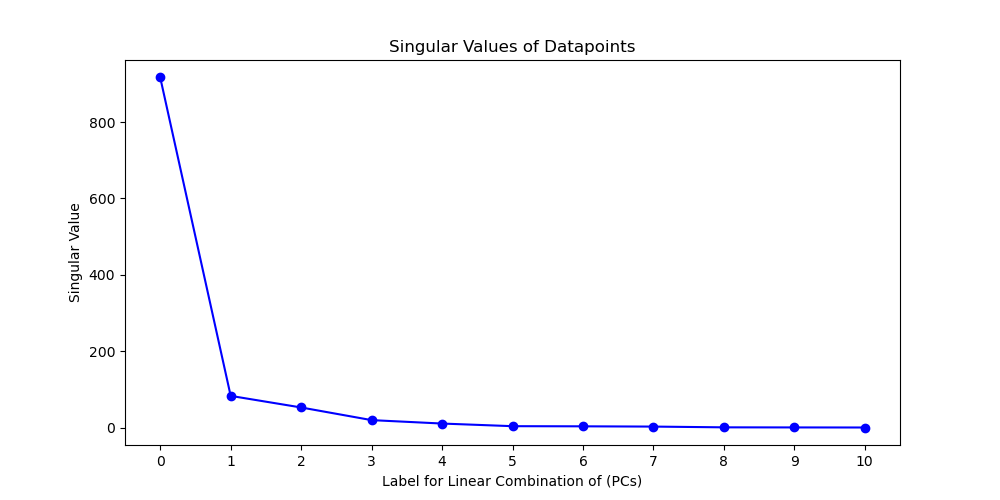

In [302]:
# Get the data for each of the pulses
values      = cp.array([values_of_interest(*data[:2],order=2,mysize=1/30) for data in tqdm(the_data)])

# Center data
mu          = cp.tile(np.mean(values,axis=0),len(values)).reshape(values.shape)
X_centered  = (values-mu)
X_centered  = X_centered / cp.tile(np.max(X_centered,axis=0)-cp.min(X_centered,axis=0),len(X_centered)).reshape(X_centered.shape)

# Single Value Decomposition
u,s,vT      = cp.linalg.svd(X_centered)

# plot the singlar values for the  D  matrix.
# 1. Calculate the D matrix using s: D is s*s
D       = cp.asnumpy(s*s)
labels  = range(len(X_centered[0]))

# 2. Set the fig size to (15,5)
fig     = plt.figure(figsize=(10,5))
ax      = fig.add_subplot(111)

# 3. Add the line chart using plt.plot( ?? ,'bo-')
ax.plot(labels,D,'bo-')

# 3. Add proper tital, ticks, axis labels
ax.set_title('Singular Values of Datapoints')
ax.set_xlabel('Label for Linear Combination of (PCs)')
ax.set_ylabel('Singular Value')
ax.set_xticks(labels)
# ax.set_yscale('log')

# Obtaining our compressed data representation:
# 1. Determine at least k singular values that are needed to represent the data set from the fig above
k = np.array(list(labels))

# 2. Obtain the first k of v^T and store it
v = vT[k].T

# 3. Calculate the compressed data using np.matmul(), X and stored first k of v^T
X_compressed = cp.matmul(X_centered,v).get()

# 4. Print the compressed value of X
#print(v)

plt.show()

# K-Means++ Clustering

<function __main__.<lambda>(sel)>

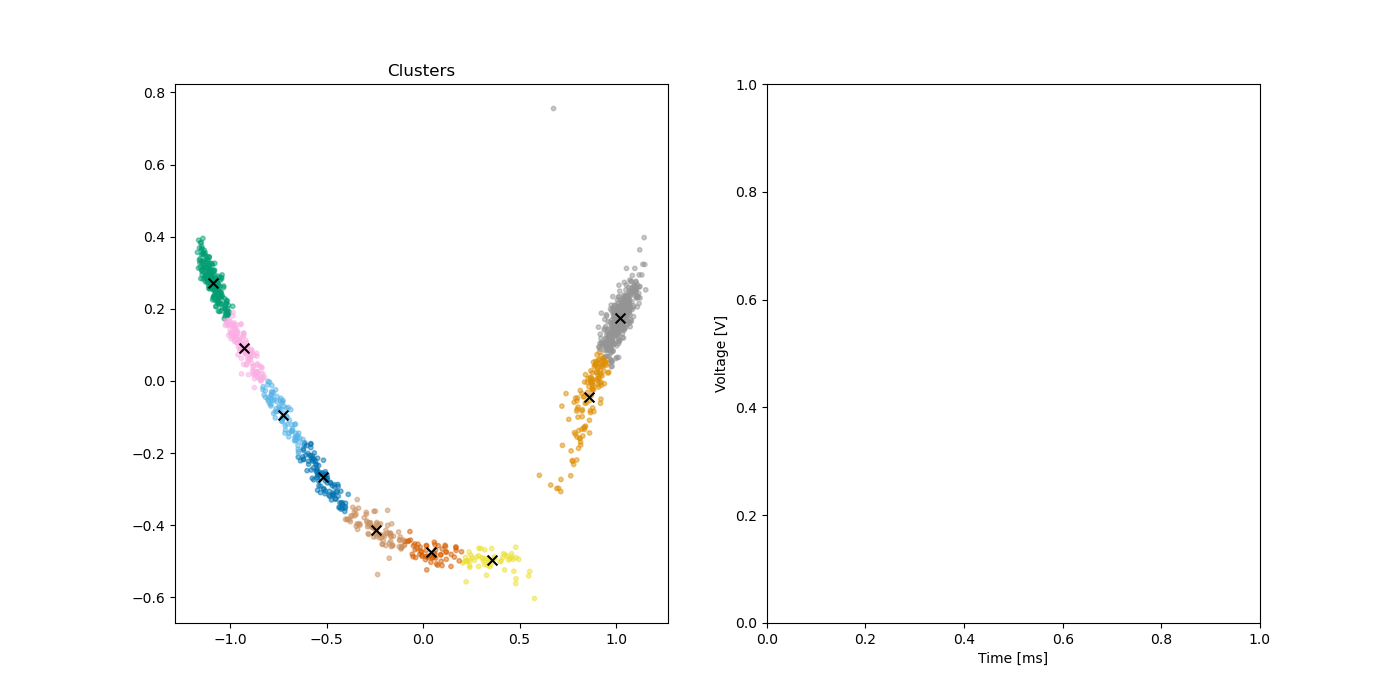

In [707]:
%matplotlib widget
# PARAMETERS
N_CLUSTERS  = 9
pyper       = []

sns.set_palette("colorblind")
# Get the centers
DATA    = X_compressed[:,[0,1]]

kmeans  = KMeans(n_clusters=N_CLUSTERS, n_init="auto").fit(DATA)
closestpoints=[]

fig     = plt.figure(figsize = (14,7))
ax1     = fig.add_subplot(121)
ax2     = fig.add_subplot(122)
# Create a colormap from the Seaborn palette
colorblind_palette = sns.color_palette("colorblind")
cmap = ListedColormap(colorblind_palette)
COLORS  = np.array([kmeans.predict([x[:2]])[0] for x in DATA])
norm    = matplotlib.colors.Normalize(vmin=COLORS.min(),vmax=COLORS.max())
points  = ax1.scatter(*(DATA.T),s=10,alpha=0.5,c=cmap(norm(COLORS)))
centers = ax1.scatter(*kmeans.cluster_centers_.T,color='k',marker='x',s=50)
ax1.set_title('Clusters')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Voltage [V]')
IDX_SELECTED  = []

cursor_p = mplcursors.cursor(points)

def callback(sel):
    I = sel.index
    cursor_p.visible = True
    cursor_c.visible = False
    sel.annotation.set_text(sel.index)
    fig.suptitle(f'Idx {I}')
    ax2.clear()
    pyper.append(I)

    plot_signal(the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
    plot_signal(the_data[I][1],fig=fig,ax=ax2,order=2,mysize=1/50,color='k',lw=1)
    ax2.plot(REFERENCE_VOLTAGE*the_data[I][1].min()/REFERENCE_VOLTAGE.min(), color='deepskyblue',lw=1,ls=(0,(5,10)))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="]-", fc="k")
    CC = ['k']*9
    CC[COLORS[I]] = 'deeppink'
    centers.set_color(CC)

    # val    = values[I]
    # function_name = ["fwhm", "peakheight/area", "time_at_98_perc", "(meantime-time[peak])/peakheight", "std", "area", "np.sqrt(np.mean(grad**2))", "grad_min", "grad_max", "np.max(corr)"]
    # max_name_width = max(len(name) for name in function_name)
    # print("-" * (max_name_width + 30))
    # print(f"{[I]},{'Name':<{max_name_width}}\tResult")
    # for i, name in enumerate(function_name):
    #     result = val[i]
    #     print(f"{name:<{max_name_width}}\t{result}")
    
cursor_p.connect("add", lambda sel: callback(sel))


cursor_c = mplcursors.cursor(centers)

def callback_center(sel):
    I = sel.index
    idx_c = np.where(COLORS==I)[0]
    sel.annotation.set_text(len(idx_c))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="wedge", fc="k")
    fig.suptitle(f'Center {I}')
    ax2.clear()
    cursor_p.visible = False
    cursor_c.visible = True
    #pyperclip.copy(", ".join([str(i) for i in idx_c]))
    #PYPER = eval("[" + ", ".join([str(i) for i in idx_c]) + "]")
    pyper.append(idx_c)
    print(len([str(i) for i in idx_c]))
    print((", ".join([str(i) for i in idx_c])))
    CC = ['k']*9
    CC[I] = 'cornflowerblue'
    centers.set_color(CC)

    ax2.set_title(f'Number of Points {len(idx_c)}')
    for i in idx_c:
        #plot_signal(the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
        plot_signal(the_data[i][1],fig=fig,ax=ax2,order=2,mysize=1/50,lw=1,label=f'{i}')
    
cursor_c.connect('add', lambda sel:callback_center(sel))

In [309]:
print(pyper)
# print(len(pyper[1]))
reduced = []
reduced.append(pyper[1])
# reduced.append(pyper[3])
reduced = np.concatenate(reduced)
print(reduced)

[874, array([   1,    2,    8,   16,   21,   43,   54,   56,   63,   81,   82,
        105,  109,  112,  114,  117,  118,  119,  120,  123,  124,  125,
        126,  127,  128,  129,  130,  131,  132,  133,  134,  135,  136,
        137,  138,  139,  145,  150,  151,  152,  153,  154,  155,  156,
        157,  158,  159,  160,  161,  162,  163,  164,  165,  166,  167,
        168,  169,  170,  171,  172,  173,  174,  175,  176,  177,  179,
        180,  181,  182,  183,  184,  186,  187,  188,  189,  190,  191,
        192,  193,  194,  195,  197,  198,  199,  200,  201,  202,  203,
        210,  235,  237,  238,  255,  259,  260,  261,  262,  263,  264,
        265,  266,  267,  268,  269,  270,  271,  272,  273,  274,  275,
        276,  277,  278,  279,  280,  281,  282,  283,  284,  285,  286,
        287,  288,  289,  290,  291,  292,  293,  294,  295,  296,  297,
        298,  299,  300,  301,  302,  303,  304,  305,  306,  307,  308,
        309,  310,  311,  312,  313,  319,  3

In [700]:
def values_of_interest_red(time,data,order=2,mysize=1/50):
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,data)
    
    peak            = np.argmin(butterybiscuits)
    area            = np.sum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    peakheight      = np.min(butterybiscuits)
    halfheights     = np.where(butterybiscuits-peakheight/2<0)[0]
    fwhm            = 0 if len(halfheights)<1 else time[halfheights[-1]]-time[halfheights[0]]
    noize           = len([x for x in data if x>0.0055])
    medheight       = np.median(butterybiscuits)
    meanheight      = np.mean(butterybiscuits)
    meantime        = np.mean(np.abs(butterybiscuits)*(time))/np.sum(np.abs(butterybiscuits[:-1])*(time[1:]-time[:-1]))
    std             = np.std(butterybiscuits)
    grad            = (butterybiscuits[1:]-butterybiscuits[:-1])/(time[1:]-time[:-1])
    grad_min        = np.mean(grad[np.where(grad<0)])
    grad_max        = np.mean(grad[np.where(grad>0)])
    corr            = signal.correlate(butterybiscuits/np.min(butterybiscuits)*np.min(REFERENCE_VOLTAGE),REFERENCE_VOLTAGE)
    area_cumulative = np.cumsum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    cumt_percentage = area_cumulative/area
    percentage      = 0.96
    time_at_94_perc = time[np.argmax(cumt_percentage >= percentage)]
    time_under_trig = len([x for x in butterybiscuits if x >= -0.032])
    
    return (peakheight, time_under_trig, time[peak]/meantime ,noize, area/std, time_at_94_perc, np.max(corr))

  0%|          | 0/480 [00:00<?, ?it/s]

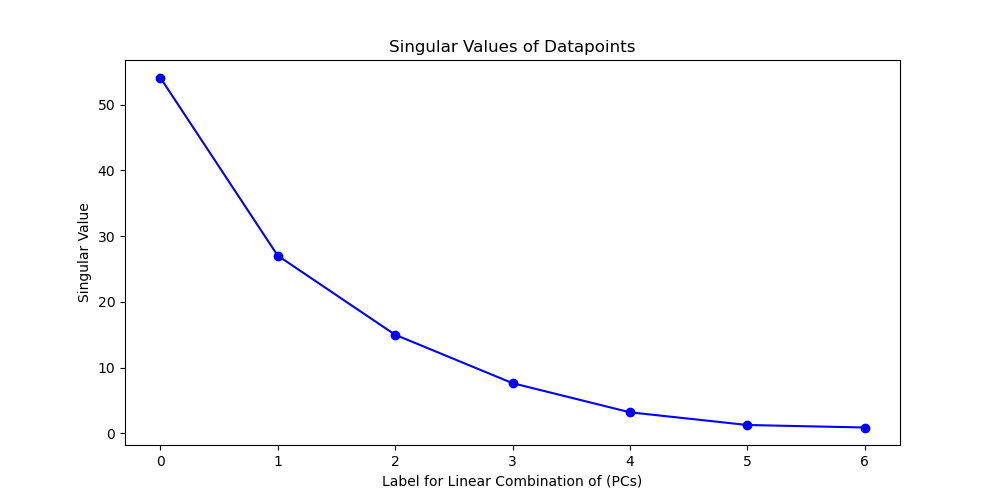

In [701]:
# Get the data for each of the pulses
reduced_the_data = []
for x in reduced:
    reduced_the_data.append(the_data[x])
values_red      = cp.array([values_of_interest_red(*data[:2],order=2,mysize=1/250) for data in tqdm(reduced_the_data)])

# Center data
mu_red          = cp.tile(np.mean(values_red,axis=0),len(values_red)).reshape(values_red.shape)
X_centered_red  = (values_red-mu_red)
X_centered_red  = X_centered_red / cp.tile(np.max(X_centered_red,axis=0)-cp.min(X_centered_red,axis=0),len(X_centered_red)).reshape(X_centered_red.shape)

# Single Value Decomposition
u_red,s_red,vT_red      = cp.linalg.svd(X_centered_red)

# plot the singlar values for the  D  matrix.
# 1. Calculate the D matrix using s: D is s*s
D_red       = cp.asnumpy(s_red*s_red)
labels_red  = range(len(X_centered_red[0]))

# 2. Set the fig size to (15,5)
fig_red     = plt.figure(figsize=(10,5))
ax_red      = fig_red.add_subplot(111)

# 3. Add the line chart using plt.plot( ?? ,'bo-')
ax_red.plot(labels_red,D_red,'bo-')

# 3. Add proper tital, ticks, axis labels_red
ax_red.set_title('Singular Values of Datapoints')
ax_red.set_xlabel('Label for Linear Combination of (PCs)')
ax_red.set_ylabel('Singular Value')
ax_red.set_xticks(labels_red)
# ax_red.set_yscale('log')

# Obtaining our compressed data representation:
# 1. Determine at least k singular values that are needed to represent the data set from the fig above
k_red = np.array(list(labels_red))

# 2. Obtain the first k of v^T and store it
v_red = vT_red[k_red].T

# 3. Calculate the compressed data using np.matmul(), X and stored first k of v^T
X_compressed_red = cp.matmul(X_centered_red,v_red).get()

plt.show()

<function __main__.<lambda>(sel)>

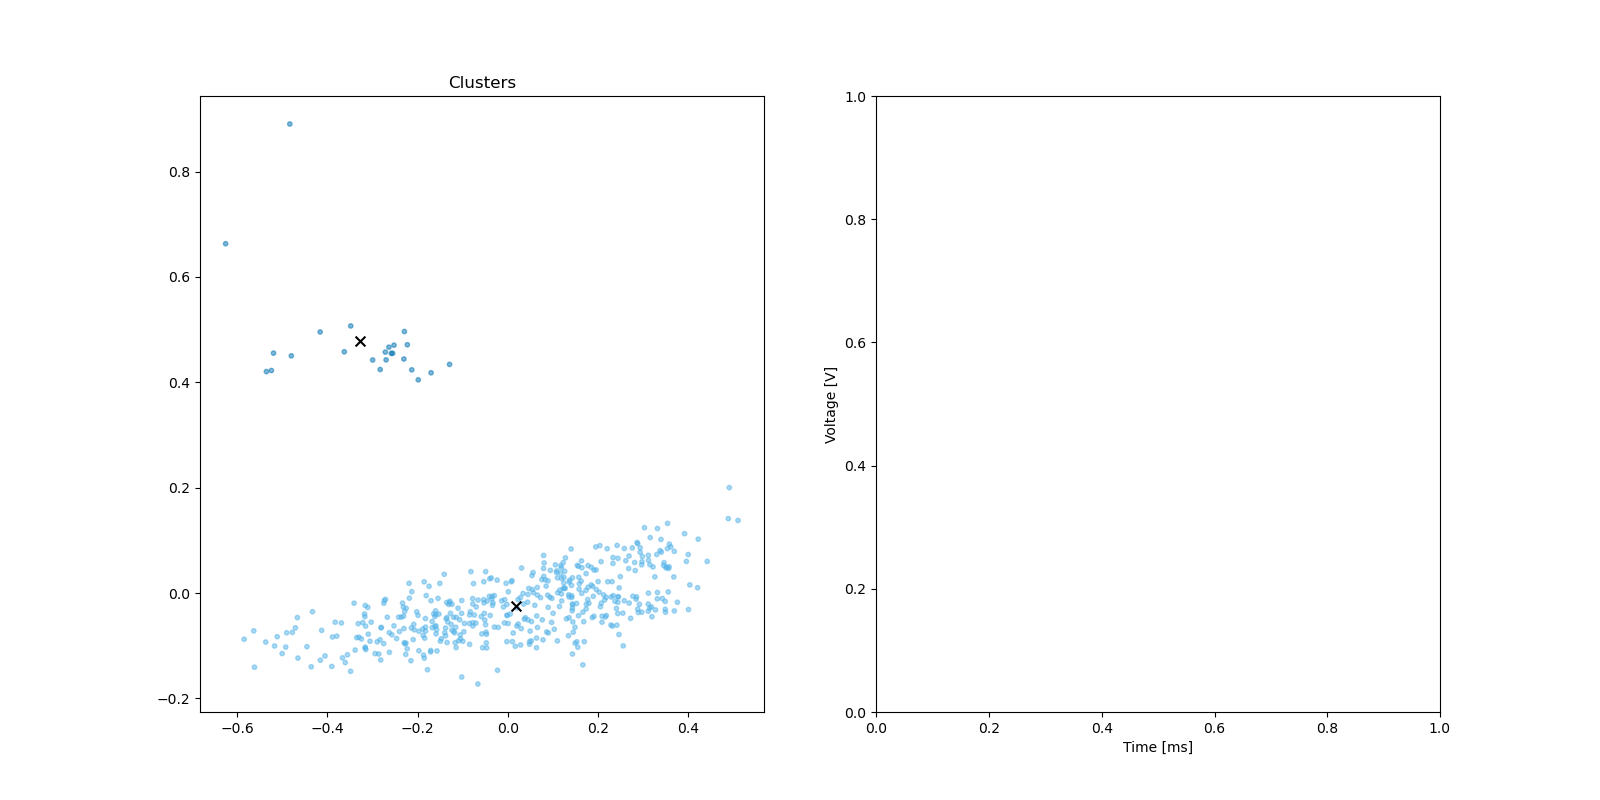

24
0, 2, 3, 4, 8, 11, 36, 147, 205, 208, 210, 215, 231, 309, 310, 314, 428, 450, 462, 463, 470, 472, 473, 475


In [704]:
%matplotlib widget
# PARAMETERS
N_CLUSTERS_red  = 2
pyper_red       = []
sns.set_palette("colorblind")
# Get the centers_red
DATA_red    = X_compressed_red[:,[1,3]] #X_centered[:,[0,-1]] #

colorblind_palette = sns.color_palette("colorblind")
cmap = ListedColormap(colorblind_palette)

kmeans_red  = KMeans(n_clusters=N_CLUSTERS_red, n_init="auto").fit(DATA_red)
closestpoints_red=[]

fig     = plt.figure(figsize = (16,8))
ax1     = fig.add_subplot(121)
ax2     = fig.add_subplot(122)

COLORS_red  = np.array([kmeans_red.predict([x[:2]])[0] for x in DATA_red])
norm    = matplotlib.colors.Normalize(vmin=COLORS_red.min(),vmax=COLORS_red.max())
points_red  = ax1.scatter(*(DATA_red.T),s=10,alpha=0.5,c=cmap(norm(COLORS_red)))
centers_red = ax1.scatter(*kmeans_red.cluster_centers_.T,color='k',marker='x',s=50)
ax1.set_title('Clusters')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Voltage [V]')
IDX_SELECTED  = []

cursor_p = mplcursors.cursor(points_red)

def callback(sel):
    I = sel.index
    cursor_p.visible = True
    cursor_c.visible = False
    sel.annotation.set_text(sel.index)
    fig.suptitle(f'Idx {I}')
    ax2.clear()
    pyper_red.append(I)
    plot_signal(reduced_the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
    plot_signal(reduced_the_data[I][1],fig=fig,ax=ax2,order=2,mysize=1/50,color='k',lw=1)
    ax2.plot(REFERENCE_VOLTAGE*reduced_the_data[I][1].min()/REFERENCE_VOLTAGE.min(), color='deepskyblue',lw=1,ls=(0,(5,10)))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="]-", fc="k")
    CC = ['k']*9
    CC[COLORS_red[I]] = 'deeppink'
    centers_red.set_color(CC)

    # val    = values[I]
    # function_name = ["fwhm", "peakheight/area", "time_at_98_perc", "(meantime-time[peak])/peakheight", "std", "area", "np.sqrt(np.mean(grad**2))", "grad_min", "grad_max", "np.max(corr)"]
    # max_name_width = max(len(name) for name in function_name)
    # print("-" * (max_name_width + 30))
    # print(f"{[I]},{'Name':<{max_name_width}}\tResult")
    # for i, name in enumerate(function_name):
    #     result = val[i]
    #     print(f"{name:<{max_name_width}}\t{result}")
    
cursor_p.connect("add", lambda sel: callback(sel))

cursor_c = mplcursors.cursor(centers_red)

def callback_center(sel):
    I = sel.index
    idx_c = np.where(COLORS_red==I)[0]
    sel.annotation.set_text(len(idx_c))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="wedge", fc="k")
    fig.suptitle(f'Center {I}')
    ax2.clear()
    cursor_p.visible = False
    cursor_c.visible = True
    #pyperclip.copy(", ".join([str(i) for i in idx_c]))
    #PYPER = eval("[" + ", ".join([str(i) for i in idx_c]) + "]")
    pyper_red.append(idx_c)
    print(len([str(i) for i in idx_c]))
    print((", ".join([str(i) for i in idx_c])))
    CC = ['k']*9
    CC[I] = 'cornflowerblue'
    centers_red.set_color(CC)

    ax2.set_title(f'Number of Points {len(idx_c)}')
    for i in idx_c:
        #plot_signal(the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
        plot_signal(reduced_the_data[i][1],fig=fig,ax=ax2,order=2,mysize=1/50,lw=1,label=f'{i}')
    
cursor_c.connect('add', lambda sel:callback_center(sel))

[-0.24688840098679066, -0.02770674042403698, -0.3539885305799544, -0.1074091624468565, -0.16967667965218425, -0.3390443264506757, -0.04016024386510253, -0.05510444799438119, -0.3116466188803315]
[2, 5, 8, 0, 4, 3, 7, 6, 1]


ValueError: Unrecognized marker style 'A'

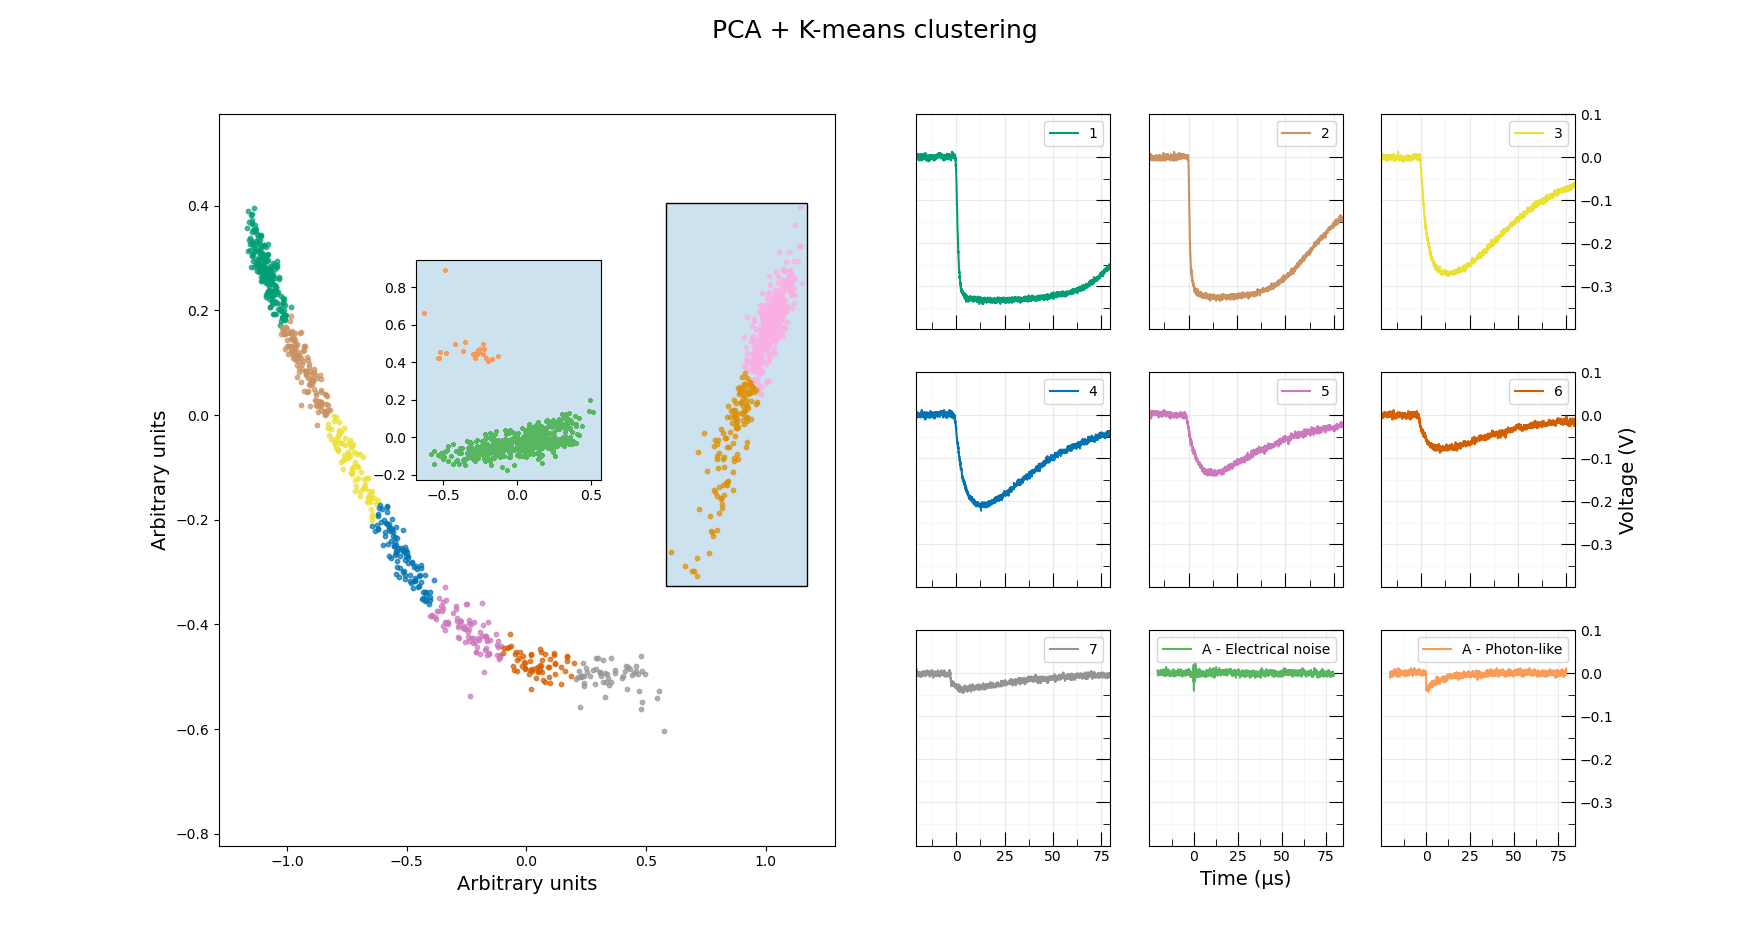

In [726]:
# Set the Seaborn color palette to "colorblind"
sns.set_palette("colorblind")
colorblind_palette = sns.color_palette("colorblind")
cmap    = ListedColormap(colorblind_palette)
mainalpha = 0.7

def format_axes(ax):
    ax.xaxis.set_ticks([0, 25, 50, 75], minor=False)
    ax.xaxis.set_ticks(np.arange(-12.5, 76, 25), minor=True)
    ax.yaxis.set_ticks([-0.3, -0.2, -0.1, 0, 0.1], minor=False)
    ax.yaxis.set_ticks(np.arange(-0.4, 0, 0.05), minor=True)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='both', which='major', labelsize=10, length=10, direction='in')
    ax.tick_params(axis='both', which='minor', length=5, direction='in')
    ax.grid(True, which='major', alpha=0.25)
    ax.grid(True, which='minor', alpha=0.1)

# Set the overall figure size to hold two 9x9 cm squares side by side with small spacing
fig = plt.figure(figsize=(17.5, 9.5))  # A bit larger to account for spacing
fig.suptitle('PCA + K-means clustering', fontsize=18)  # Add the main title for the figure

# Create the main square (9x9 cm) for the first set of data
main_ax = plt.subplot2grid((1, 2), (0, 0), colspan=1)
face = (*colorblind_palette[0], 0.2)
ax_sub = main_ax.inset_axes([0.32, 0.5, 0.3, 0.3], facecolor=face)
x_min = np.min([DATA[i][0] for i in reduced])-0.02
x_max = np.max([DATA[i][0] for i in reduced])+0.02
y_min = np.min([DATA[i][1] for i in reduced])-0.02
y_max = np.max([DATA[i][1] for i in reduced])-0.35
# Calculate the coordinates for the rectangle
roi_rectangle = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth = 1, edgecolor='k', facecolor=face)
main_ax.add_patch(roi_rectangle)

# main_ax.set_title('Clusters',fontsize=16)
main_ax.set_ylabel('Arbitrary units',fontsize=14)
main_ax.set_xlabel('Arbitrary units',fontsize=14)
main_ax.set_ylim(np.min(DATA[1])-0.6, np.max(DATA[1])-0.2)
main_ax.margins()

cluster_min = []
# Create the 9 subplots in a 3x3 grid within the second square
for i in range(3):
    for j in range(3):
        # Calculate the color for the subplot from the Seaborn "colorblind" palette
        k   = [l for l, cluster in enumerate(COLORS) if cluster == 3*i+j]
        cluster_v = []
        for m in k:
            cluster_v.append([the_data[m][1][900:1000]])
        
        cluster_min.append((np.concatenate(cluster_v)).min())
        
print(cluster_min)
sorted_clusters = [cluster for _, cluster in sorted(zip(cluster_min, range(9)))]
print(sorted_clusters)
axes = [[None, None, None], [None, None, None], [None, None, None]]
for u, cluster_number in enumerate(sorted_clusters):
    # Map the cluster_number to the (i, j) grid position
    i, j = divmod(u, 3)

    # Get the corresponding color for the cluster
    color = sns.color_palette("colorblind")[cluster_number]

    ax = plt.subplot2grid((3, 6), (i, j + 3), colspan=1)
    k = [l for l, cluster in enumerate(COLORS) if cluster == cluster_number]

    # Plot the cluster points on the main_ax (assuming main_ax exists)
    main_ax.scatter(*(DATA[k].T), s=10, alpha=mainalpha, color=color)
    
    rep = np.random.choice(k)
    x_sub = the_data[rep][0] * 10**6
    y_sub = the_data[rep][1]
    ax.plot(x_sub, y_sub, color=color)

    x_min = ((np.concatenate([data[0] for data in the_data])).ravel()).min()
    x_max = ((np.concatenate([data[0] for data in the_data])).ravel()).max()
    y_min = ((np.concatenate([data[1] for data in the_data])).ravel()).min()
    y_max = ((np.concatenate([data[1] for data in the_data])).ravel()).max()
    ax.set_xlim(x_min * 10**6, x_max * 10**6)
    ax.set_ylim(y_min, y_max)
    ax.margins(0)

    # Simplify the x-axis for non-bottom subplots


    if i == 2:
        if j == 1:
            ax.set_xlabel(f'Time (\u03BCs)',fontsize=14)

    # Move the y-axis to the right side for the rightmost subplots
    
    if j == 2:
        if i == 1:
            ax.set_ylabel(f'Voltage (V)',fontsize=14)
            
    
    format_axes(ax)
       # Hide y tick labels on non-leftmost subplots
    if j < 2:
       ax.set_yticklabels([])
        # Hide x tick labels on non-bottom subplots
    if i < 2:
        ax.set_xticklabels([])
    
    axes[i][j] = ax 
    # Label each subplot with a legend indicating its number
    ax.legend([f'{3*i+j+ 1}'])
    

for i in COLORS_red:
    if i==0:
        axs = axes[2][2]
        # Get the corresponding color for the cluster
        colors = sns.color_palette("RdYlGn", 10)[2]
        o = [l for l, cluster in enumerate(COLORS_red) if cluster == 0]
        # Plot the cluster points on the main_ax (assuming main_ax exists)
        ax_sub.scatter(*(DATA_red[o].T), s=3, alpha=0.75, color=colors)
        # ax = plt.subplot2grid((3, 6), (1, 2), colspan=1)
        rep = np.random.choice(o)
        x_sub = reduced_the_data[rep][0] * 10**6
        y_sub = reduced_the_data[rep][1]
        axs.clear()
        axs.plot(x_sub, y_sub, color=colors)
        format_axes(axs)
        axs.legend([f'A - Photon-like'])
        
        
    else:
        axs = axes[2][1]
        # Get the corresponding color for the cluster
        colors = sns.color_palette("RdYlGn", 10)[-2]
        o = [l for l, cluster in enumerate(COLORS_red) if cluster == 1]
        # Plot the cluster points on the main_ax (assuming main_ax exists)
        ax_sub.scatter(*(DATA_red[o].T), s=3, alpha=0.75, color=colors)
        # ax = plt.subplot2grid((3, 6), (2, 2), colspan=1)
        rep = np.random.choice(o)
        x_sub = reduced_the_data[rep][0] * 10**6
        y_sub = reduced_the_data[rep][1]
        axs.cla()
        axs.plot(x_sub, y_sub, color=colors)
        format_axes(axs)
        axs.set_yticklabels([])
        axs.legend([f'A - Electrical noise'])
        axs.set_xlabel(f'Time (\u03BCs)',fontsize=14)

ax_sub.scatter(*kmeans_red.cluster_centers_[0],color='k',marker= f'A',s=100)
ax_sub.scatter(*kmeans_red.cluster_centers_[1],color='k',marker= f'B',s=100)

# Adjust spacing to fill the square and include small gaps between plots
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, wspace=0.1, hspace=0.1)
for i in range(9):
    if i == 8:
        main_ax.scatter(*kmeans.cluster_centers_[sorted_clusters[i]],color='k',marker= f'${8}$',s=100,alpha=mainalpha)
    elif i == 7:
        main_ax.scatter(*kmeans.cluster_centers_[sorted_clusters[i]],color='k',marker= f'${9}$',s=100,alpha=mainalpha)
    else:
        main_ax.scatter(*kmeans.cluster_centers_[sorted_clusters[i]],color='k',marker= f'${i+1}$',s=100,alpha=mainalpha)
# Display the figure
plt.show()

In [352]:
print(pyper_red)

reduced2 = []
for i in [0,1,3]:
    reduced2.append(pyper_red[i])
reduced2 = np.concatenate(reduced2)
print(reduced2)

[]


IndexError: list index out of range

In [74]:
print(pyper_red[0])
dt = [reduced_the_data[i][2]['TRIGGER_TIME'] for i in pyper_red[0]]
print(dt)
# Sort the datetime objects
sorted_event_times = sorted(dt)

# Calculate the time elapsed from the start for each event
time_elapsed = [(event - sorted_event_times[0]).total_seconds() for event in sorted_event_times]

# Set the maximum number of events to display on the y-axis
max_events = len(sorted_event_times)

# Plotting
fig, ax = plt.subplots()
ax.scatter(time_elapsed, range(1, len(sorted_event_times) + 1), marker='o', s=50)  # Adjust 's' for marker size
ax.set_xlabel('Time elapsed (seconds)')
ax.set_ylabel('Event occurrence')
ax.set_title('Events over Time')

# Set y-axis limits
ax.set_ylim(1, max_events)

# Format y-axis ticks as event numbers
ax.set_yticks(np.arange(0, max_events + 4, 2))

# Format x-axis as time
# ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))

plt.grid(False)
plt.show()

11


TypeError: 'numpy.int32' object is not iterable

In [ ]:
print(pyper_red)

reduced2 = []
for i in [0,1,3]:
    reduced2.append(pyper_red[i])
reduced2 = np.concatenate(reduced2)
print(reduced2)

[array([ 32,  68,  91,  95, 166, 179]), array([  2,   5,  34,  35,  36,  50, 129, 132, 139, 144, 156, 176, 190,
       191, 215, 219, 231, 240, 248, 277, 296, 308, 320, 323, 330, 338,
       357, 360, 368, 371, 382, 385, 404, 411]), 218, array([  0,  24,  27,  29,  40,  44,  54,  61,  69,  71,  74,  80,  87,
        93,  94, 103, 104, 109, 110, 119, 120, 123, 136, 137, 147, 157,
       164, 174, 175, 184, 186, 187, 188, 197, 199, 200, 201, 214, 218,
       220, 223, 228, 242, 247, 257, 263, 264, 271, 281, 285, 292, 295,
       302, 310, 312, 322, 356, 358, 359, 369, 372, 374, 393, 399, 401,
       403, 419, 424, 433, 434, 436, 439, 445, 456, 457])]
[ 32  68  91  95 166 179   2   5  34  35  36  50 129 132 139 144 156 176
 190 191 215 219 231 240 248 277 296 308 320 323 330 338 357 360 368 371
 382 385 404 411   0  24  27  29  40  44  54  61  69  71  74  80  87  93
  94 103 104 109 110 119 120 123 136 137 147 157 164 174 175 184 186 187
 188 197 199 200 201 214 218 220 223 228 242 247 25

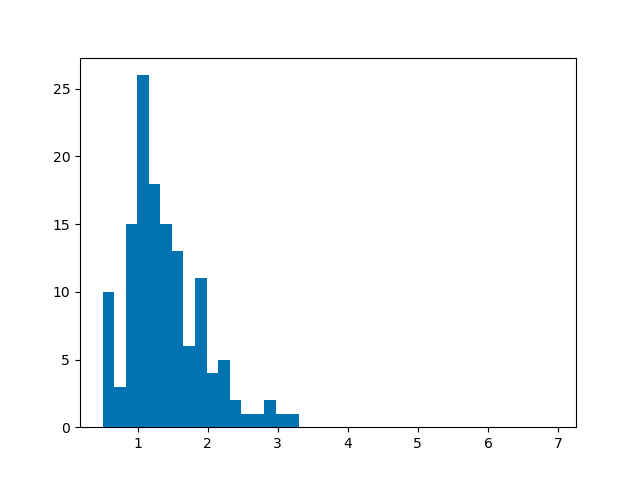

139


In [ ]:
eng = []
for i in reduced2:
    eng.append((np.abs(np.min(reduced_the_data[i][1]))-0.0095)/0.0277)

for i in redred:
    eng.append((np.abs(np.min(reduced_the_data_2[i][1]))-0.0095)/0.0277)

def E(A):
    E = (np.abs(np.min(A))-0.0095)/0.0277
    return(E)
bins = np.arange(0.5, 7, 0.165)
plt.figure()
plt.hist(eng, bins = bins)
plt.show()
print(len(eng))

In [ ]:
def B(A):
    B = (np.abs(np.min(A))-0.0095)/0.0277
    return(B)

photon_energy  = []
for i in pyper_red[0]:
    photon_energy.append(B(reduced_the_data[i][1]))

print(photon_energy)

[1.1613556419899318, 1.0714386496356678, 0.981521657281404]


In [ ]:
def values_of_interest_red_2(time,data,order=2,mysize=1/50):
    sos=signal.butter(order,mysize, output='sos')
    butterybiscuits=signal.sosfilt(sos,data)
    
    peak            = np.argmin(butterybiscuits)
    area            = np.sum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    peakheight      = np.min(butterybiscuits)
    halfheights     = np.where(butterybiscuits-peakheight/2<0)[0]
    fwhm            = 0 if len(halfheights)<1 else time[halfheights[-1]]-time[halfheights[0]]
    noize           = len([x for x in data if x>0.0015])
    medheight       = np.median(butterybiscuits)
    meanheight      = np.mean(butterybiscuits)
    meantime        = np.mean(np.abs(butterybiscuits)*(time))/np.sum(np.abs(butterybiscuits[:-1])*(time[1:]-time[:-1]))
    std             = np.std(butterybiscuits)
    grad            = (butterybiscuits[1:]-butterybiscuits[:-1])/(time[1:]-time[:-1])
    grad_min        = np.mean(time[np.where(grad<0)])
    grad_max        = np.mean(time[np.where(grad>0)])
    corr            = signal.correlate(butterybiscuits/np.min(butterybiscuits)*np.min(REFERENCE_VOLTAGE),REFERENCE_VOLTAGE)
    area_cumulative = np.cumsum(butterybiscuits[:-1]*(time[1:]-time[:-1]))
    cumt_percentage = area_cumulative/area
    percentage      = 0.985
    time_at_93_perc = time[np.argmax(cumt_percentage >= percentage)]
    time_under_trig = len([x for x in butterybiscuits if x >= -0.030])
    
    return (time_at_93_perc, area, fwhm, time_under_trig, peakheight, noize, time[peak]/meantime , np.max(corr))

In [ ]:
# Get the data for each of the pulses
reduced_the_data_2 = []
for x in reduced2:
    reduced_the_data_2.append(reduced_the_data[x])
values_red_2      = cp.array([values_of_interest_red_2(*data[:2],order=2,mysize=1/125) for data in tqdm(reduced_the_data_2)])

# Center data
mu_red_2          = cp.tile(np.mean(values_red_2,axis=0),len(values_red_2)).reshape(values_red_2.shape)
X_centered_red_2  = (values_red_2-mu_red_2)
X_centered_red_2  = X_centered_red_2 / cp.tile(np.max(X_centered_red_2,axis=0)-cp.min(X_centered_red_2,axis=0),len(X_centered_red_2)).reshape(X_centered_red_2.shape)

# Single Value Decomposition
u_red_2,s_red_2,vT_red_2      = cp.linalg.svd(X_centered_red_2)

  0%|          | 0/206 [00:00<?, ?it/s]

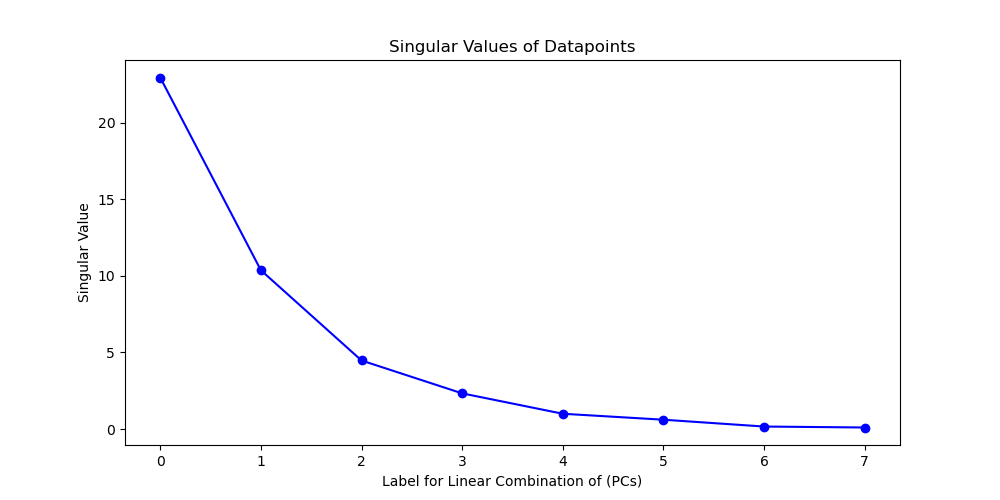

In [ ]:
# plot the singlar values for the  D  matrix.
# 1. Calculate the D matrix using s: D is s*s
D_red_2       = cp.asnumpy(s_red_2*s_red_2)
labels_red_2  = range(len(X_centered_red_2[0]))

# 2. Set the fig size to (15,5)
fig_red_2     = plt.figure(figsize=(10,5))
ax_red_2      = fig_red_2.add_subplot(111)

# 3. Add the line chart using plt.plot( ?? ,'bo-')
ax_red_2.plot(labels_red_2,D_red_2,'bo-')

# 3. Add proper tital, ticks, axis labels_red_2
ax_red_2.set_title('Singular Values of Datapoints')
ax_red_2.set_xlabel('Label for Linear Combination of (PCs)')
ax_red_2.set_ylabel('Singular Value')
ax_red_2.set_xticks(labels_red_2)
# ax_red_2.set_yscale('log')

plt.show()

In [ ]:
# Obtaining our compressed data representation:
# 1. Determine at least k singular values that are needed to represent the data set from the fig above
k_red_2 = np.array(list(labels_red_2))

# 2. Obtain the first k of v^T and store it
v_red_2 = vT_red_2[k_red_2].T

# 3. Calculate the compressed data using np.matmul(), X and stored first k of v^T
X_compressed_red_2 = cp.matmul(X_centered_red_2,v_red_2).get()

In [ ]:
# PARAMETERS
N_CLUSTERS_red_2  = 5
pyper_red_2       = []

<function __main__.<lambda>(sel)>

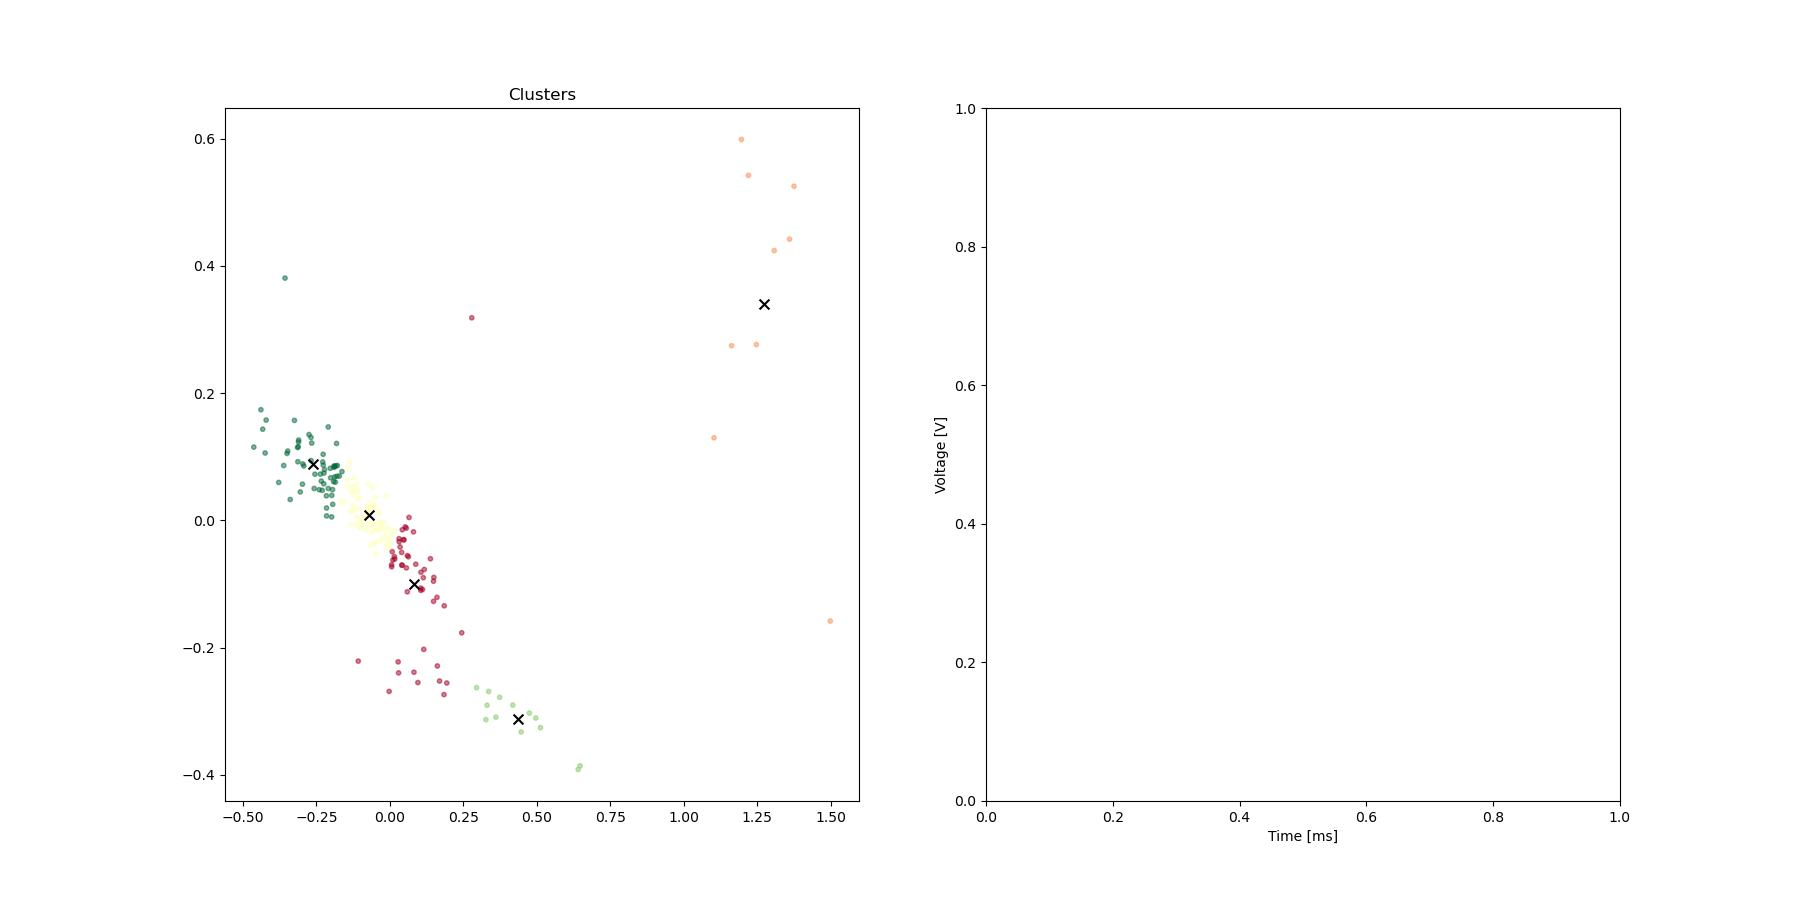

13
10, 11, 24, 40, 46, 51, 70, 76, 78, 80, 84, 88, 111


In [ ]:
%matplotlib widget

# Get the centers_red_2
DATA_red_2    = X_compressed_red_2[:,[0,2]] #X_centered[:,[0,-1]] #

# params = {
#     "n_neighbors": 100,
#     "n_components": 2,
#     "eigen_solver": "dense",
#     "random_state": 0,
#     }

# lle_hessian = manifold.LocallyLinearEmbedding(method="hessian", **params)
# DATA_red_2 = lle_hessian.fit_transform(DATA_red_2)

kmeans_red_2  = KMeans(n_clusters=N_CLUSTERS_red_2, n_init="auto").fit(DATA_red_2)
closestpoints_red_2=[]

fig     = plt.figure(figsize = (18,9))
ax1     = fig.add_subplot(121)
ax2     = fig.add_subplot(122)
cmap    = matplotlib.cm.get_cmap('RdYlGn')
COLORS_red_2  = np.array([kmeans_red_2.predict([x[:2]])[0] for x in DATA_red_2])
norm    = matplotlib.colors.Normalize(vmin=COLORS_red_2.min(),vmax=COLORS_red_2.max())
points_red_2  = ax1.scatter(*(DATA_red_2.T),s=10,alpha=0.5,c=cmap(norm(COLORS_red_2)))
centers_red_2 = ax1.scatter(*kmeans_red_2.cluster_centers_.T,color='k',marker='x',s=50)
ax1.set_title('Clusters')
ax2.set_xlabel('Time [ms]')
ax2.set_ylabel('Voltage [V]')
IDX_SELECTED  = []

cursor_p = mplcursors.cursor(points_red_2)

def callback(sel):
    I = sel.index
    cursor_p.visible = True
    cursor_c.visible = False
    sel.annotation.set_text(sel.index)
    fig.suptitle(f'Idx {I}')
    ax2.clear()
    pyper_red_2.append(I)
    plot_signal(reduced_the_data_2[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
    plot_signal(reduced_the_data_2[I][1],fig=fig,ax=ax2,order=2,mysize=1/50,color='k',lw=1)
    ax2.plot(REFERENCE_VOLTAGE*reduced_the_data_2[I][1].min()/REFERENCE_VOLTAGE.min(), color='deepskyblue',lw=1,ls=(0,(5,10)))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="]-", fc="k")
    CC = ['k']*9
    CC[COLORS_red_2[I]] = 'deeppink'
    centers_red_2.set_color(CC)

    # val    = values[I]
    # function_name = ["fwhm", "peakheight/area", "time_at_98_perc", "(meantime-time[peak])/peakheight", "std", "area", "np.sqrt(np.mean(grad**2))", "grad_min", "grad_max", "np.max(corr)"]
    # max_name_width = max(len(name) for name in function_name)
    # print("-" * (max_name_width + 30))
    # print(f"{[I]},{'Name':<{max_name_width}}\tResult")
    # for i, name in enumerate(function_name):
    #     result = val[i]
    #     print(f"{name:<{max_name_width}}\t{result}")
    
cursor_p.connect("add", lambda sel: callback(sel))

cursor_c = mplcursors.cursor(centers_red_2)

def callback_center(sel):
    I = sel.index
    idx_c = np.where(COLORS_red_2==I)[0]
    sel.annotation.set_text(len(idx_c))
    sel.annotation.get_bbox_patch().set(fc="white",lw=0,alpha=0)
    sel.annotation.arrow_patch.set(arrowstyle="wedge", fc="k")
    fig.suptitle(f'Center {I}')
    ax2.clear()
    cursor_p.visible = False
    cursor_c.visible = True
    #pyperclip.copy(", ".join([str(i) for i in idx_c]))
    #PYPER = eval("[" + ", ".join([str(i) for i in idx_c]) + "]")
    pyper_red_2.append(idx_c)
    print(len([str(i) for i in idx_c]))
    print((", ".join([str(i) for i in idx_c])))
    CC = ['k']*9
    CC[I] = 'cornflowerblue'
    centers_red_2.set_color(CC)

    ax2.set_title(f'Number of Points {len(idx_c)}')
    for i in idx_c:
        #plot_signal(the_data[I][1],fig=fig,ax=ax2,order=0,mysize=1/50,color='k',alpha=0.2,lw=0.5)
        plot_signal(reduced_the_data_2[i][1],fig=fig,ax=ax2,order=2,mysize=1/50,lw=1,label=f'{i}')
    
cursor_c.connect('add', lambda sel:callback_center(sel))

In [ ]:
def E(A):
    sos = signal.butter(2, 1/50, output='sos')
    butterybiscuits = signal.sosfilt(sos, A)
    E = (np.abs(np.min(butterybiscuits)) - 0.0091) / 0.0321
    return E

photon_energy = []
for i in pyper_red_2[1]:
    photon_energy.append(E(reduced_the_data_2[i][1]))

print("Minimum Values: ", end="")
minimum_values = [f"{i}: {np.min(reduced_the_data_2[i][1]):.2f}" for i in pyper_red_2[1]]
print(", ".join(minimum_values))

print("Photon Energies: ", end="")
energy_strings = [f"{energy:.2f}eV" for energy in photon_energy]
print(", ".join(energy_strings))

IndexError: list index out of range

[-0.24190699961036444, -0.02770674042403698, -0.3539885305799544, -0.10491846175864339, -0.3091559181921184, -0.04016024386510253, -0.05510444799438119, -0.16469527827575803, -0.3390443264506757]
[2, 8, 4, 0, 7, 3, 6, 5, 1]


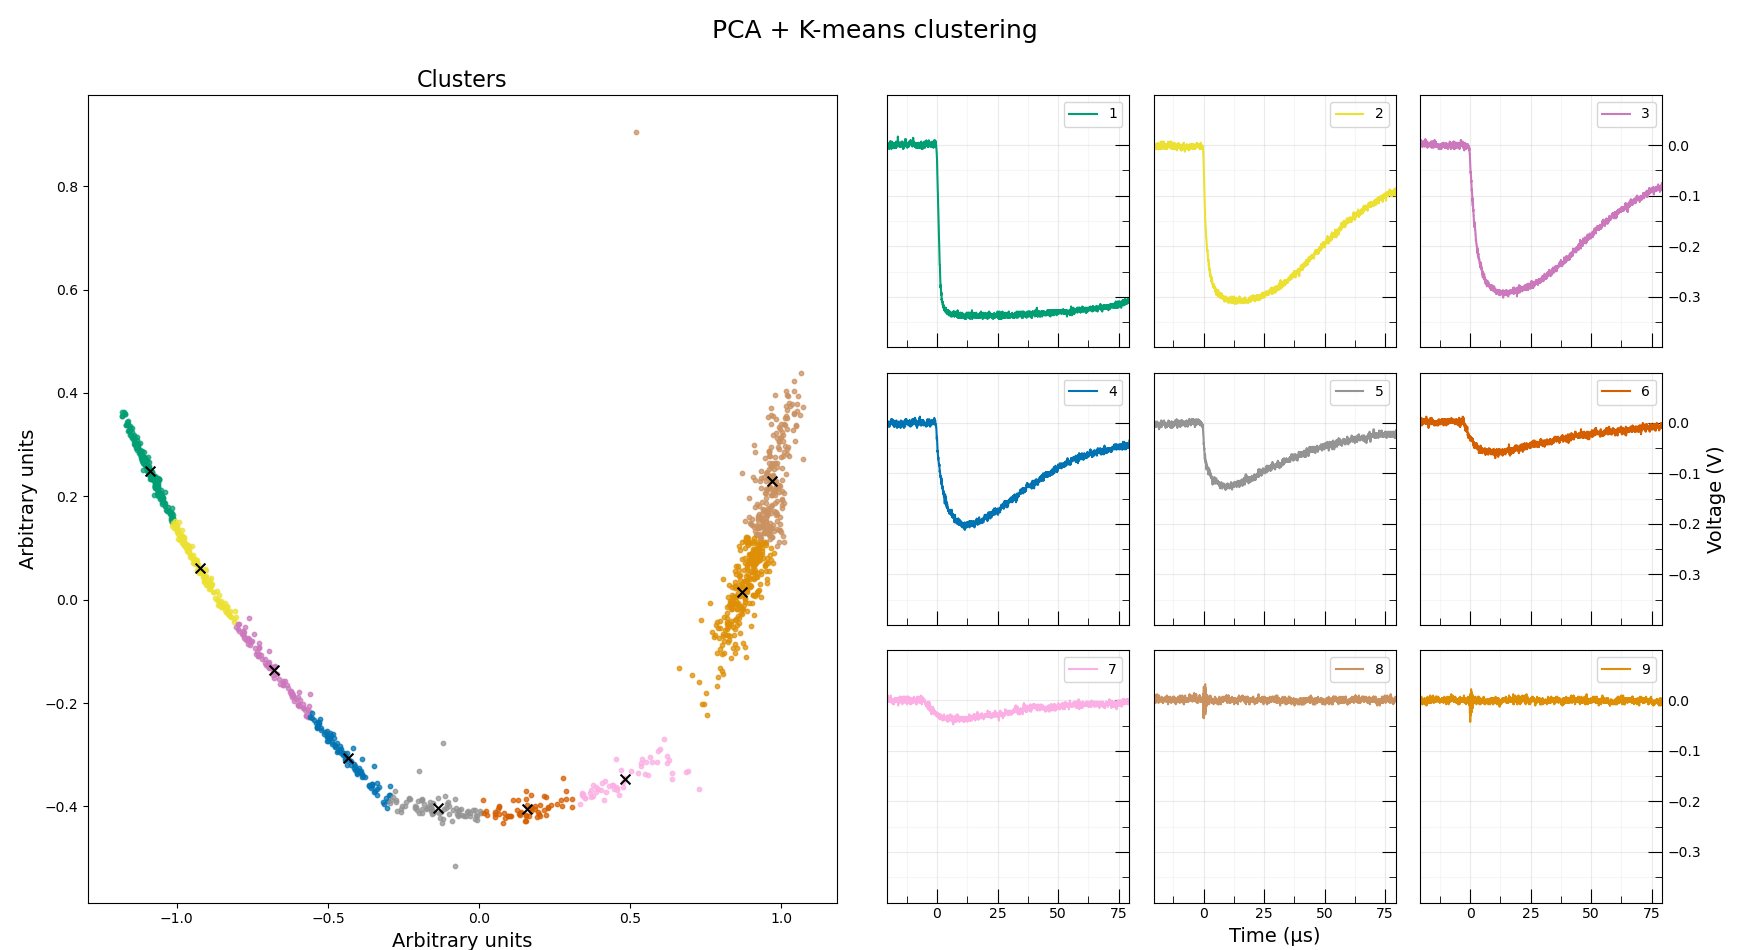

In [ ]:
# Set the Seaborn color palette to "colorblind"
sns.set_palette("colorblind")

# We will use a colormap to get a gradient of colors for the subplots
DATA    = X_compressed[:,[0,1]] #X_centered[:,[0,-1]] #
kmeans  = KMeans(n_clusters=N_CLUSTERS, n_init="auto").fit(DATA)
closestpoints=[]

# Set the overall figure size to hold two 9x9 cm squares side by side with small spacing
fig = plt.figure(figsize=(17.5, 9.5))  # A bit larger to account for spacing
fig.suptitle('PCA + K-means clustering', fontsize=18)  # Add the main title for the figure

# Create the main square (9x9 cm) for the first set of data
main_ax = plt.subplot2grid((1, 2), (0, 0), colspan=1)

colorblind_palette = sns.color_palette("colorblind")
cmap    = ListedColormap(colorblind_palette)
COLORS  = np.array([kmeans.predict([x[:2]])[0] for x in DATA])
# norm    = matplotlib.colors.Normalize(vmin=COLORS.min(),vmax=COLORS.max())
# points  = main_ax.scatter(*(DATA.T),s=10,alpha=0.5,c=cmap(norm(COLORS)))

main_ax.set_title('Clusters',fontsize=16)
main_ax.set_ylabel('Arbitrary units',fontsize=14)
main_ax.set_xlabel('Arbitrary units',fontsize=14)
main_ax.margins()

cluster_min = []
# Create the 9 subplots in a 3x3 grid within the second square
for i in range(3):
    for j in range(3):
        # Calculate the color for the subplot from the Seaborn "colorblind" palette
        k   = [l for l, cluster in enumerate(COLORS) if cluster == 3*i+j]
        cluster_v = []
        for m in k:
            cluster_v.append([the_data[m][1][900:1000]])
        
        cluster_min.append((np.concatenate(cluster_v)).min())
        
print(cluster_min)
sorted_clusters = [cluster for _, cluster in sorted(zip(cluster_min, range(9)))]
print(sorted_clusters)

for i, cluster_number in enumerate(sorted_clusters):
    # Map the cluster_number to the (i, j) grid position
    i, j = divmod(i, 3)

    # Get the corresponding color for the cluster
    color = sns.color_palette("colorblind")[cluster_number]

    ax = plt.subplot2grid((3, 6), (i, j + 3), colspan=1)
    k = [l for l, cluster in enumerate(COLORS) if cluster == cluster_number]

    # Plot the cluster points on the main_ax (assuming main_ax exists)
    main_ax.scatter(*(DATA[k].T), s=10, alpha=0.75, color=color)
    rep = np.random.choice(k)
    x_sub = the_data[rep][0] * 10**6
    y_sub = the_data[rep][1]
    ax.plot(x_sub, y_sub, color=color)

    x_min = ((np.concatenate([data[0] for data in the_data])).ravel()).min()
    x_max = ((np.concatenate([data[0] for data in the_data])).ravel()).max()
    y_min = ((np.concatenate([data[1] for data in the_data])).ravel()).min()
    y_max = ((np.concatenate([data[1] for data in the_data])).ravel()).max()
    ax.set_xlim(x_min * 10**6, x_max * 10**6)
    ax.set_ylim(y_min, y_max)
    ax.margins(0)

    # Simplify the x-axis for non-bottom subplots


    if i == 2:
        if j == 1:
            ax.set_xlabel(f'Time (\u03BCs)',fontsize=14)

    # Move the y-axis to the right side for the rightmost subplots
    
    if j == 2:
        if i == 1:
            ax.set_ylabel(f'Voltage (V)',fontsize=14)
            
    
    ax.xaxis.set_ticks([0, 25, 50, 75], minor = False)
    ax.xaxis.set_ticks(np.arange(-12.5, 76, 25), minor = True)
    ax.yaxis.set_ticks([-0.3, -0.2, -0.1, 0], minor = False)
    ax.yaxis.set_ticks(np.arange(-0.4, 0, 0.05), minor=True)
    ax.yaxis.set_label_position("right")
     # Display y and x ticks on all subplots
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('bottom')

    ax.tick_params(axis='both', which='major', labelsize=10, length=10, direction='in')  # Major tick length
    ax.tick_params(axis='both', which='minor', length=5, direction='in') 
    ax.grid(True, which = 'major', alpha = 0.25)
    ax.grid(True, which = 'minor', alpha = 0.1)
       # Hide y tick labels on non-leftmost subplots
    if j < 2:
       ax.set_yticklabels([])
        # Hide x tick labels on non-bottom subplots
    if i < 2:
        ax.set_xticklabels([])
    # Label each subplot with a legend indicating its number
    ax.legend([f'{3*i+j+ 1}'])



centers = main_ax.scatter(*kmeans.cluster_centers_.T,color='k',marker='x',s=50)
# Adjust spacing to fill the square and include small gaps between plots
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.9, wspace=0.1, hspace=0.1)

# Display the figure
plt.show()